In [1]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
import os

%matplotlib inline
pd.set_option('display.max_columns', 500)

## Business Understanding

**Company Overview**  
Airbnb, Inc. operates an online community marketplace for people to list, discover, and book accommodations worldwide online. It also allows to book from a mobile phone to individuals and businesses. It allows its users to share their travel experiences. The company allows people to rent out their extra space and showcase it to audience. It also publishes an online travel magazine under the brand name Airbnbmag. Airbnb, Inc. was formerly known as AirBed & Breakfast, Inc. and changed its name to Airbnb, Inc. in March 2009. The company was founded in 2008 and is based in San Francisco, California, with offices across North America, Europe, and Asia. Source: Bloomberg.com  

How much or how many change the price? (regression)   
Which category produce more money? (classification)   
Which zones has more poirnts? (clustering)   
Which option should be taken a host to improve their value? (recommendation)   
Can you describe the vibe of each Boston neighborhood using listing descriptions?  
What are the busiest times of the year to visit Boston? By how much do prices spike?  
Is there a general upward trend of both new Airbnb listings and total Airbnb visitors to Boston?  




## Data Understading
**Data Source**  
https://www.kaggle.com/airbnb/seattle/kernels  
https://www.kaggle.com/airbnb/boston  

**Description**  
The following Airbnb activity is included in this Boston and Seattle dataset: * Listings, including full descriptions and average review score * Reviews, including unique id for each reviewer and detailed comments * Calendar, including listing id and the price and availability for that day  


**Enviroment**  Size, shape, type,head   


In [2]:

seattle_calendar = pd.read_csv("https://raw.githubusercontent.com/Zhitaow/Airbnb-Data-Analysis/master/seattle/calendar.csv")
seattle_listing = pd.read_csv("https://raw.githubusercontent.com/Zhitaow/Airbnb-Data-Analysis/master/seattle/listings.csv")
seattle_reviews = pd.read_csv("https://raw.githubusercontent.com/Zhitaow/Airbnb-Data-Analysis/master/seattle/reviews.csv")
boston_calendar = pd.read_csv("https://raw.githubusercontent.com/Zhitaow/Airbnb-Data-Analysis/master/boston-airbnb-open-data/calendar.csv")
boston_listing = pd.read_csv("https://raw.githubusercontent.com/Zhitaow/Airbnb-Data-Analysis/master/boston-airbnb-open-data/listings.csv")
boston_reviews = pd.read_csv("https://raw.githubusercontent.com/Zhitaow/Airbnb-Data-Analysis/master/boston-airbnb-open-data/reviews.csv")

1
2


In [3]:
print("""Shapes
        seattle_calendar {}
        seattle_listing {}
        seattle_reviews {}
        boston_calendar {}
        boston_listing {}
        boston_reviews {}
        """.format(seattle_calendar.shape, seattle_listing.shape, 
                   seattle_reviews.shape,boston_calendar.shape, 
                   boston_listing.shape, boston_reviews.shape
                  )
     )



Shapes
seattle_calendar (1393570, 4)
seattle_listing (3818, 92)
seattle_reviews (84849, 6)
boston_calendar (1308890, 4)
boston_listing (3585, 95)
boston_reviews (68275, 6)



Look for differents columns between Seattle and Boston

In [4]:
print(set(seattle_calendar.columns).symmetric_difference(set(boston_calendar.columns))) 
print(set(seattle_reviews.columns).symmetric_difference(set(boston_reviews.columns)))
print(set(seattle_listing.columns).symmetric_difference(set(boston_listing.columns)))

Look for differents columns between Seattle and Boston
set()
set()
{'house_rules', 'access', 'interaction'}


In [5]:
seattle_calendar.head()

,listing_id,date,available,price
0,241032,2016-01-04,t,$85.00
1,241032,2016-01-05,t,$85.00
2,241032,2016-01-06,f,NaN
3,241032,2016-01-07,f,NaN
4,241032,2016-01-08,f,NaN


In [6]:
boston_calendar.head()

,listing_id,date,available,price
0,12147973,2017-09-05,f,NaN
1,12147973,2017-09-04,f,NaN
2,12147973,2017-09-03,f,NaN
3,12147973,2017-09-02,f,NaN
4,12147973,2017-09-01,f,NaN


In [7]:
seattle_reviews.head()

,listing_id,id,date,reviewer_id,reviewer_name,comments
0,7202016,38917982,2015-07-19,28943674,Bianca,Cute and cozy place. Perfect location to every...
1,7202016,39087409,2015-07-20,32440555,Frank,Kelly has a great room in a very central locat...
2,7202016,39820030,2015-07-26,37722850,Ian,"Very spacious apartment, and in a great neighb..."
3,7202016,40813543,2015-08-02,33671805,George,Close to Seattle Center and all it has to offe...
4,7202016,41986501,2015-08-10,34959538,Ming,Kelly was a great host and very accommodating ...


In [8]:
boston_reviews.head()

,listing_id,id,date,reviewer_id,reviewer_name,comments
0,1178162,4724140,2013-05-21,4298113,Olivier,My stay at islam's place was really cool! Good...
1,1178162,4869189,2013-05-29,6452964,Charlotte,Great location for both airport and city - gre...
2,1178162,5003196,2013-06-06,6449554,Sebastian,We really enjoyed our stay at Islams house. Fr...
3,1178162,5150351,2013-06-15,2215611,Marine,The room was nice and clean and so were the co...
4,1178162,5171140,2013-06-16,6848427,Andrew,Great location. Just 5 mins walk from the Airp...


## Data Preperation
Now, we go through the lengthy process of preparing our data. We go through the following phases:  

- Drop intesection 

- Identify Datasets

- Concat

- Handle Missing Values Columms  

- Keep features to analyze 

- Formatting 

- Handle Missing Values Rows 

- Categorical variables 


### Drop intersection

In [11]:
colums_todrop = list(set(seattle_listing.columns).symmetric_difference(set(boston_listing.columns)))
boston_listing.drop(labels = colums_todrop, axis = 1, inplace = True)


### Identify Datasets  


In [12]:
boston_reviews['city'], seattle_reviews['city'] = 'Boston', 'Seattle'
boston_calendar['city'],seattle_calendar['city'] = 'Boston', 'Seattle'
boston_listing['city'], seattle_listing['city'] = 'Boston', 'Seattle'


### Concatenating Datasets  
I divided the analysis in three parts. 
1. Time series using calendars data  
2. Features analysis using listing
3. Reviews for sentiment Analysis

In [584]:
reviews = pd.concat([boston_reviews, seattle_reviews]).reset_index(drop = True)
calendar = pd.concat([boston_calendar,seattle_calendar]).reset_index(drop = True)
listing = pd.concat([boston_listing, seattle_listing]).reset_index(drop = True)

### Handle Missing Values Columms

0                         license
1                     square_feet
2                   monthly_price
3                    weekly_price
4                security_deposit
5                has_availability
6    neighbourhood_group_cleansed
7              jurisdiction_names
8                           notes
Name: Feature, dtype: object

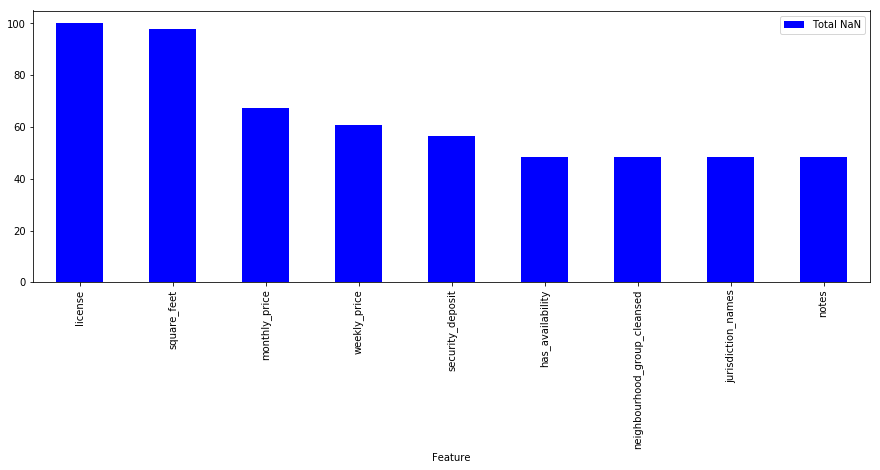

In [585]:
def missing_data(df, level = 5):
    
    try:
        missings = (df.isnull().sum()/len(df)*100).sort_values(ascending=False)
        missings = pd.DataFrame({'Feature':missings.index, 'Total NaN':missings.values})
        missings[missings['Total NaN'] > level].plot.bar(x='Feature', y='Total NaN', figsize=(15, 5), color = 'blue')
        display(missings[missings['Total NaN'] > level]['Feature'])
        return missings
    except:
        print("Not feature with more than {}% NaNs".format(level))
        
def drop_missings(df, missings, thresold = 5):
    outliers = missings[missings["Total NaN"] >=  thresold]['Feature']
    display(outliers)
    df.drop(outliers, axis=1, inplace=True)
    
    
missings = missing_data(listing, 40)


0                         license
1                     square_feet
2                   monthly_price
3                    weekly_price
4                security_deposit
5                has_availability
6    neighbourhood_group_cleansed
7              jurisdiction_names
8                           notes
Name: Feature, dtype: object

0                         license
1                     square_feet
2                   monthly_price
3                    weekly_price
4                security_deposit
5                has_availability
6    neighbourhood_group_cleansed
7              jurisdiction_names
8                           notes
Name: Feature, dtype: object

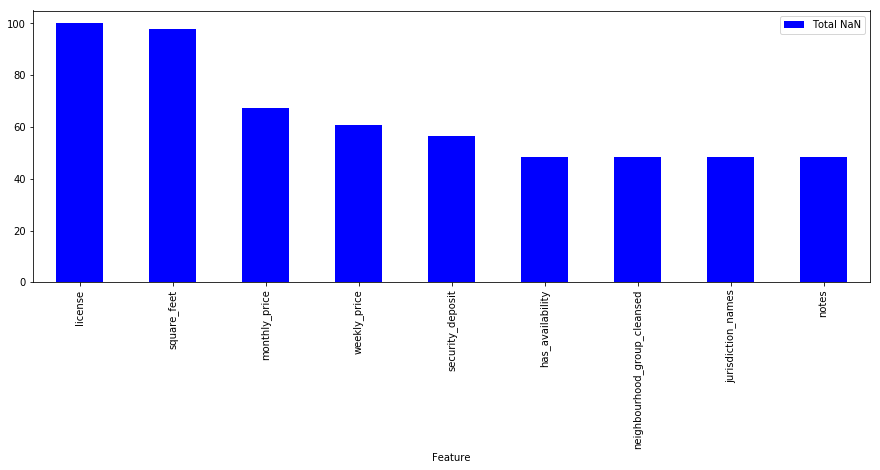

In [586]:
missings = missing_data(listing, 40)
drop_missings(listing,missings, 40)


0    price
Name: Feature, dtype: object

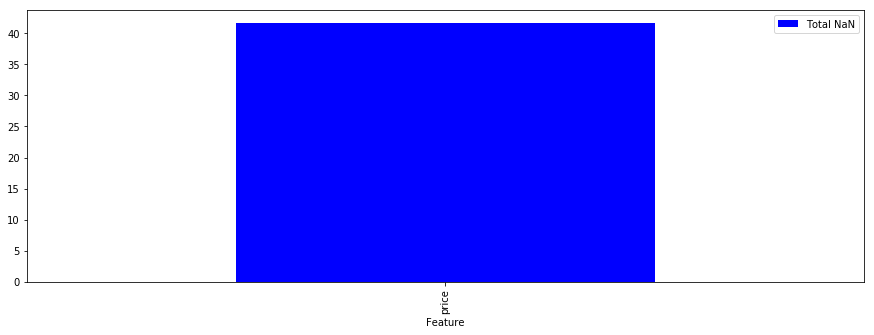

In [587]:
missings = missing_data(calendar, 40)


As prices is the the target variable I don't dropout it

### Keep features to analyze


In [588]:
display(listing.head(1))

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,transit,thumbnail_url,medium_url,picture_url,xl_picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,street,neighbourhood,neighbourhood_cleansed,city,state,zipcode,market,smart_location,country_code,country,latitude,longitude,is_location_exact,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,price,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,calendar_updated,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,requires_license,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,12147973,https://www.airbnb.com/rooms/12147973,20160906204935,2016-09-07,Sunny Bungalow in the City,"Cozy, sunny, family home. Master bedroom high...",The house has an open and cozy feel at the sam...,"Cozy, sunny, family home. Master bedroom high...",none,"Roslindale is quiet, convenient and friendly. ...","The bus stop is 2 blocks away, and frequent. B...",https://a2.muscache.com/im/pictures/c0842db1-e...,https://a2.muscache.com/im/pictures/c0842db1-e...,https://a2.muscache.com/im/pictures/c0842db1-e...,https://a2.muscache.com/im/pictures/c0842db1-e...,31303940,https://www.airbnb.com/users/show/31303940,Virginia,2015-04-15,"Boston, Massachusetts, United States",We are country and city connecting in our deck...,NaN,NaN,NaN,f,https://a2.muscache.com/im/pictures/5936fef0-b...,https://a2.muscache.com/im/pictures/5936fef0-b...,Roslindale,1.0,1.0,"['email', 'phone', 'facebook', 'reviews']",t,f,"Birch Street, Boston, MA 02131, United States",Roslindale,Roslindale,Boston,MA,02131,Boston,"Boston, MA",US,United States,42.282619,-71.133068,t,House,Entire home/apt,4,1.5,2.0,3.0,Real Bed,"{TV,""Wireless Internet"",Kitchen,""Free Parking ...",$250.00,$35.00,1,$0.00,2,1125,2 weeks ago,0,0,0,0,2016-09-06,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,f,f,moderate,f,f,1,NaN


**potential variable to analize**
- price
- host_is_superhost
- review_scores_value

Looking for remain nan column that might be are not necessary

In [589]:
display(listing.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7403 entries, 0 to 7402
Data columns (total 83 columns):
id                                  7403 non-null int64
listing_url                         7403 non-null object
scrape_id                           7403 non-null int64
last_scraped                        7403 non-null object
name                                7403 non-null object
summary                             7083 non-null object
space                               5777 non-null object
description                         7403 non-null object
experiences_offered                 7403 non-null object
neighborhood_overview               4956 non-null object
transit                             5179 non-null object
thumbnail_url                       6484 non-null object
medium_url                          6484 non-null object
picture_url                         7403 non-null object
xl_picture_url                      6484 non-null object
host_id                             7403

None

#### Picking location variable

#### features selection

In [590]:
listing['calculated_host_listings_count'].max()

136

In [591]:
num_col = len(listing.columns)
listing = listing[['price',
'last_scraped', 
'host_is_superhost',
'review_scores_value',
'host_since', 
'host_response_time', 
'host_response_rate', 
'host_acceptance_rate',
'host_listings_count',
'number_of_reviews',
'is_location_exact',
'property_type',
'neighbourhood_cleansed',
'room_type',
'accommodates',
'bathrooms',
'bedrooms',
'beds',
'bed_type',
'amenities',
'guests_included',
'extra_people',
'availability_30',
'availability_60',
'availability_90',
'availability_365',
'instant_bookable',
'cancellation_policy',
'require_guest_profile_picture',
'require_guest_phone_verification',
'reviews_per_month', 
'city'                
                  ]]


In [592]:
print(num_col, len(listing.columns))

83 32


### Formatting



In [593]:
def convert_to_number(df, col, sign):
    return df[col].str.strip(sign).str.replace(',', '').astype(float)

In [594]:
dollar_sign_list = ['price', 'extra_people']
percentage_sign_list = ['host_response_rate', 'host_acceptance_rate']

for col in dollar_sign_list:
    listing[col] = convert_to_number(listing, col, '$')
    
for col in percentage_sign_list:
    listing[col] = convert_to_number(listing, col, "%")

listing['host_type'] = np.where(listing['host_is_superhost'] == 't', 'Superhost', 'Normal')
listing['days_as_member'] = pd.to_datetime(listing['last_scraped']) - pd.to_datetime(listing['host_since'])

drop_list = ['host_is_superhost', 'last_scraped', 'host_since']

 


In [595]:
listing.drop(drop_list , axis=1, inplace=True)

### Handle Missing Values Rows



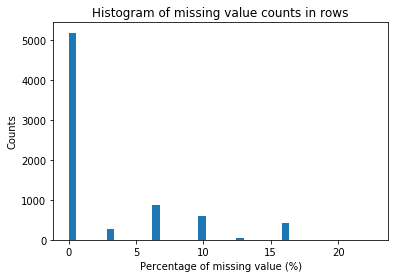

,count,weight,cumsum
"[0, 1)",5178,0.699446,0.699446
"[1, 2)",0,0.000000,0.699446
"[2, 3)",0,0.000000,0.699446
"[3, 4)",281,0.037958,0.737404
"[4, 5)",0,0.000000,0.737404
"[5, 6)",0,0.000000,0.737404
"[6, 7)",874,0.118060,0.855464
"[7, 8)",0,0.000000,0.855464
"[8, 10)",599,0.080913,0.936377
"[10, 15)",34,0.004593,0.940970


In [596]:
missings = (listing.isnull().sum(axis=1)/len(listing.columns)*100).sort_values(ascending=False)
plt.hist( missings[missings >= 0], bins=40)
plt.xlabel('Percentage of missing value (%)')
plt.ylabel('Counts')
plt.title('Histogram of missing value counts in rows')
plt.show()
#
bins = pd.cut(missings, [0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 15, 20, 30, 50, 80], right = False)
agg = pd.DataFrame(missings, columns = ['missings']).groupby(bins)['missings'].agg(['count'])
agg['weight'] = agg['count']/len(missings)
agg['cumsum'] = agg['weight'].cumsum()
agg


In [597]:
print("Percentage of data if drop all NaN {0:.2f}%".format(100- len(listing.dropna())/len(listing)*100))

Percentage of data if drop all NaN 30.06%


In [598]:
listing.dropna(inplace=True)

### Categorical variables

In [599]:
listing.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5178 entries, 1 to 7399
Data columns (total 31 columns):
price                               5178 non-null float64
review_scores_value                 5178 non-null float64
host_response_time                  5178 non-null object
host_response_rate                  5178 non-null float64
host_acceptance_rate                5178 non-null float64
host_listings_count                 5178 non-null float64
number_of_reviews                   5178 non-null int64
is_location_exact                   5178 non-null object
property_type                       5178 non-null object
neighbourhood_cleansed              5178 non-null object
room_type                           5178 non-null object
accommodates                        5178 non-null int64
bathrooms                           5178 non-null float64
bedrooms                            5178 non-null float64
beds                                5178 non-null float64
bed_type                        

In [600]:

#pd.DataFrame(listing['amenities'].str.strip('{}').str.split(',').values.tolist())
l = listing['amenities'].str.strip('{}').str.split(',').values.tolist()
listing['amenities'] = listing['amenities'].str.strip('{}').str.split(',').values.tolist()
amnities_dummies = pd.get_dummies(listing['amenities'].apply(pd.Series).stack()).sum(level=0)
amnities_dummies[amnities_dummies == 0] = 'No'
amnities_dummies[amnities_dummies == 1] = 'Yes'
amnities_dummies.pop("")


listing.pop("amenities")
for col in amnities_dummies.columns:
    #listing[col.strip('"')] = amnities_dummies[col]
    listing[col] = amnities_dummies[col]

In [601]:
"""object_cols = listing.select_dtypes(include=['category']).columns
listing[object_cols] = listing[object_cols].apply(lambda x: x.astype('category'))"""


"object_cols = listing.select_dtypes(include=['category']).columns\nlisting[object_cols] = listing[object_cols].apply(lambda x: x.astype('category'))"

In [602]:

#
"""base_color = sb.color_palette("Blues_r")[0]
amnities_dummies.count().sort_values().plot(kind = 'bar', 
                                           color = base_color,
                                           figsize= (10,5));"""

'base_color = sb.color_palette("Blues_r")[0]\namnities_dummies.count().sort_values().plot(kind = \'bar\', \n                                           color = base_color,\n                                           figsize= (10,5));'

In [605]:
listing.head(1)

,price,review_scores_value,host_response_time,host_response_rate,host_acceptance_rate,host_listings_count,number_of_reviews,is_location_exact,property_type,neighbourhood_cleansed,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,guests_included,extra_people,availability_30,availability_60,availability_90,availability_365,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,reviews_per_month,city,host_type,days_as_member,"""24-Hour Check-in""","""Air Conditioning""","""Buzzer/Wireless Intercom""","""Cable TV""","""Carbon Monoxide Detector""","""Elevator in Building""","""Family/Kid Friendly""","""Fire Extinguisher""","""First Aid Kit""","""Free Parking on Premises""","""Free Parking on Street""","""Hair Dryer""","""Hot Tub""","""Indoor Fireplace""","""Laptop Friendly Workspace""","""Lock on Bedroom Door""","""Other pet(s)""","""Paid Parking Off Premises""","""Pets Allowed""","""Pets live on this property""","""Safety Card""","""Smoke Detector""","""Smoking Allowed""","""Suitable for Events""","""Washer / Dryer""","""Wheelchair Accessible""","""Wireless Internet""","""translation missing: en.hosting_amenity_49""","""translation missing: en.hosting_amenity_50""",Breakfast,Cat(s),Dog(s),Doorman,Dryer,Essentials,Gym,Hangers,Heating,Internet,Iron,Kitchen,Pool,Shampoo,TV,Washer
1,65.0,9.0,within an hour,100.0,100.0,1.0,36,t,Apartment,Roslindale,Private room,2,1.0,1.0,1.0,Real Bed,0,0.0,26,54,84,359,t,moderate,f,f,1.3,Boston,Normal,1553 days,No,Yes,No,No,Yes,No,Yes,Yes,No,No,No,Yes,No,No,No,Yes,No,No,Yes,Yes,No,Yes,No,No,No,No,Yes,No,No,No,No,Yes,No,Yes,Yes,No,Yes,Yes,Yes,Yes,Yes,No,Yes,Yes,Yes


## Modeling
We now have data that is cleaned and not missing values. But let's break our modeling to different phases:  

a) EDA  

b) Base Model  

c) Feature Selection  

d) Improved model  

### Univariate

#### Categoricals

In [613]:
category_features = listing.select_dtypes(include=['object']).columns
print(len(category_features))

57


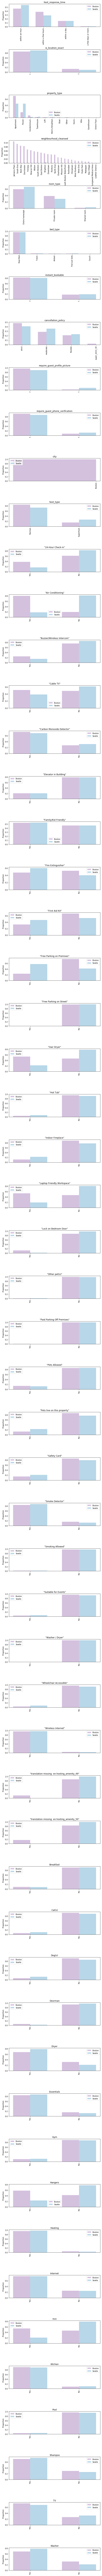

In [717]:
df = listing
plt.figure(figsize = [8,200])

rows = 57
cols = 1
count = 0
#ax, fig = plt.subplots(rows, cols)
palette = [sb.color_palette("Paired")[8], sns.color_palette("Paired")[0]]
column = category_features
for fig in range(rows*cols):
    
    #column = category_features[count]
    boston = listing.loc[listing['city'] == 'Boston', column[count]].value_counts()/len_boston
    seattle = listing.loc[listing['city'] == 'Seattle', column[count]].value_counts()/len_seattle
    n_groups = len(boston)
    index = np.arange(n_groups)
    
    if 'Yes' in boston.index:
        boston = boston.reindex(index = ['Yes', 'No'])
        seattle = seattle.reindex(index = ['Yes', 'No'])
    else:
        seattle = seattle.reindex(index = boston.index)
        
    plt.subplot(rows, cols, fig+1)
    
    rects1 = plt.bar(index, boston, bar_width,
                alpha = opacity,
                color=boston_color, 
                label='Boston')

    rects2 = plt.bar(index + bar_width, seattle, bar_width,
                alpha = opacity,
                color=seattle_color, 
                label='Seatle')
    
    plt.ylabel('Proportion')
    plt.title(column[count])
    
    plt.xticks(index + bar_width/2, (boston.index))
    plt.xticks(rotation = 90)
    plt.legend()
    plt.tight_layout()
    plt.subplots_adjust(hspace = 1)
    count += 1
plt.show()


        


#### Numerical

In [718]:
numeric_variables = listing.select_dtypes(include=['float64', 'int64', 'timedelta64' ])
len(numeric_variables.columns)

18

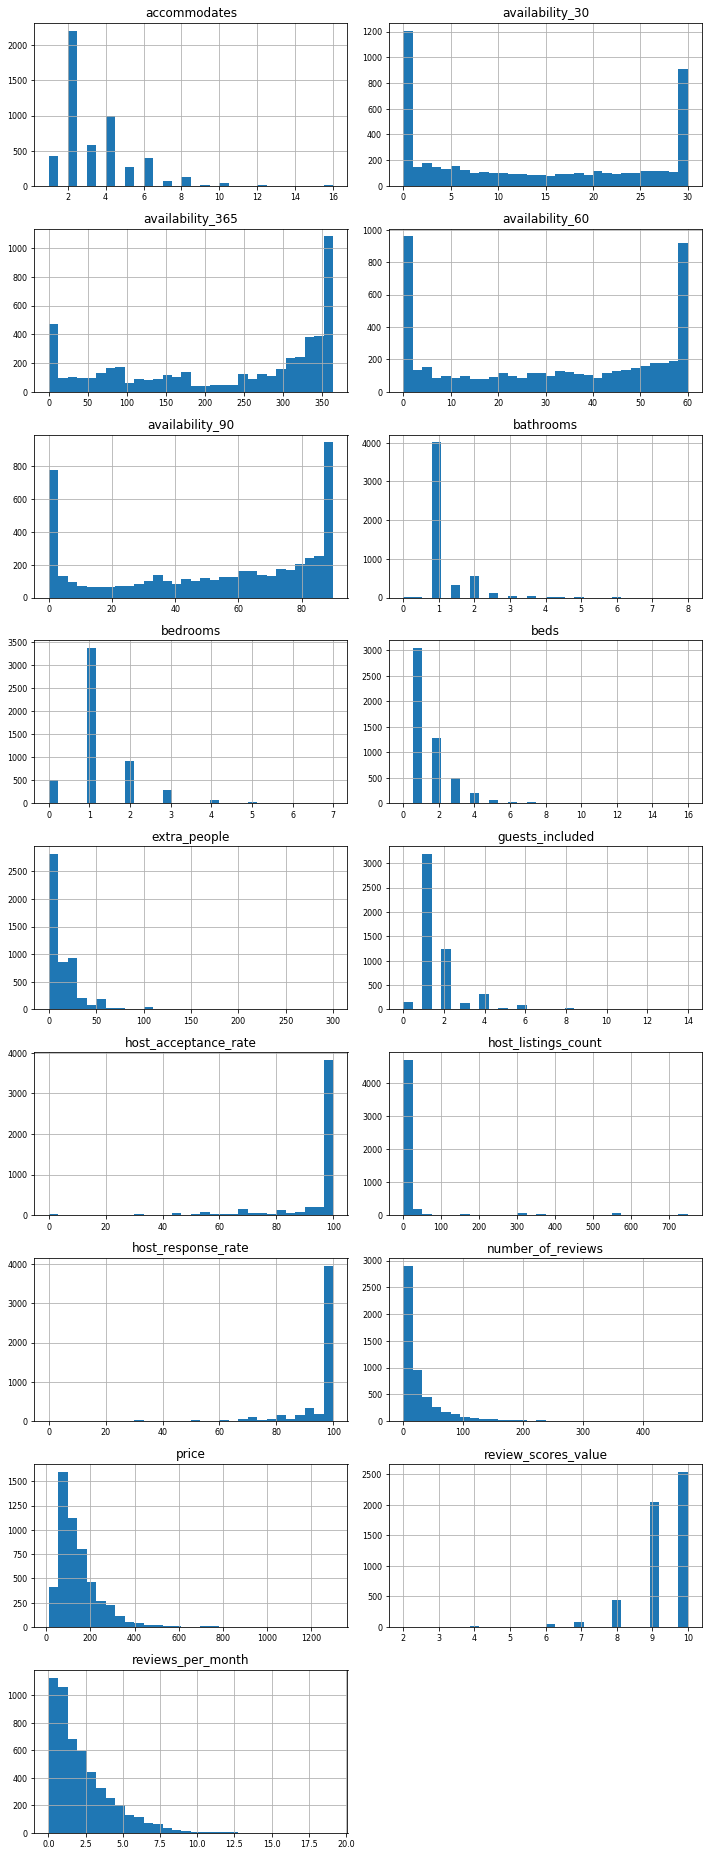

In [719]:

numeric_variables.hist(figsize = (10, 100),
                      bins=30, 
                      xlabelsize=8, 
                      ylabelsize=8, 
                      layout = (35, 2)
                      );
plt.subplots_adjust(hspace = 2);


#### Droping more feature

In [ ]:
def simple_boxplot(df, cat, num, label):
    base_color = sb.color_palette("Blues")[3]
    sb.violinplot(data = df,
              x = cat, y = num, 
              color = base_color, inner = 'quartile')
    plt.xticks(rotation = 90)
    plt.ylabel(label);
    plt.show();
simple_boxplot(df, 'host_type', 'price', 'Host type vs Price')    
# {“box”, “quartile”, “point”, “stick”, None}

## Deployment and Testing
We will deploy the model and test it on New York data. But if our assumption is that our model is general, we want to do the following:  

Use the most important features. This is to deploy a fast model.  

Remove host diff since it is asking for a variable found in listing which is a huge csv for New York for example`  

### PCA to looking clusters

In [ ]:
listing['days_as_member'] = listing['days_as_member'].astype(int)

In [ ]:

listing_dummies = pd.get_dummies(listing)
listing_dummies_boston = listing_dummies[listing_dummies['city_Boston']==1]
listing_dummies_seattle = listing_dummies[listing_dummies['city_Boston']==0]



### Boston

In [ ]:
scaler = RobustScaler()
df_std = scaler.fit_transform(listing_dummies_boston)

pca = PCA()
pca.fit(df_std)
pca_data = pca.transform(df_std)

In [ ]:
# Re-apply PCA to the data while selecting for number of components to retain.
def scree_plot(pca):
    '''
    Creates a scree plot associated with the principal components 
    
    INPUT: pca - the result of instantian of PCA in scikit learn
            
    OUTPUT:
            None
    '''
    num_components=len(pca.explained_variance_ratio_)
    ind = np.arange(num_components)
    vals = pca.explained_variance_ratio_
 
    plt.figure(figsize=(10, 6))
    ax = plt.subplot(111)
    cumvals = np.cumsum(vals)
    ax.bar(ind, vals)
    ax.plot(ind, cumvals)
    ax.xaxis.set_tick_params(width=0)
    ax.yaxis.set_tick_params(width=2, length=12)
 
    ax.set_xlabel("Principal Component")
    ax.set_ylabel("Variance Explained (%)")
    plt.title('Explained Variance Per Principal Component')
    
scree_plot(pca)

In [ ]:
pca = PCA(n_components=10)
pca.fit(df_std)
pca_data = pca.transform(df_std)

In [398]:
def get_components(components, columns, n, abs_opt = False):

    
    if abs_opt:
        for col in pca_comps.columns:
            pca_comps = pd.DataFrame(components[0:n].T, index = columns, columns = ["PCA " + str(i + 1) for i in range(n)])
            pca_comps[col] = abs(pca_comps[col].values)
    else:
            pca_comps = pd.DataFrame(components[0:n].T, index = columns, columns = ["PCA " + str(i + 1) for i in range(n)])
    
    return pca_comps

pca_boston = get_components(pca.components_, listing_dummies_seattle.columns, 2)


In [399]:
pca_boston["PCA 1"].sort_values(ascending=False).head(3)

host_listings_count               0.980331
calculated_host_listings_count    0.192345
availability_30                   0.011426
Name: PCA 1, dtype: float64

In [400]:
pca_boston["PCA 2"].sort_values(ascending=False).head(3)

host_response_time_within a day          0.017204
host_response_time_a few days or more    0.010949
cancellation_policy_flexible             0.010642
Name: PCA 2, dtype: float64

In [401]:
pca_boston["PCA 1"].sort_values(ascending=True).head(3)

host_response_rate     -0.024473
host_acceptance_rate   -0.013005
number_of_reviews      -0.009001
Name: PCA 1, dtype: float64

In [402]:
pca_boston["PCA 2"].sort_values(ascending=True).head(3)

host_response_rate               -0.997133
number_of_reviews                -0.036039
calculated_host_listings_count   -0.031322
Name: PCA 2, dtype: float64

### Seattle

In [403]:
scaler = RobustScaler()
df_std = scaler.fit_transform(listing_dummies_seattle)
pca = PCA()
pca.fit(df_std)
pca_data = pca.transform(df_std)
pca = PCA(n_components=3)
pca.fit(df_std)
pca_data = pca.transform(df_std)

In [404]:
pca_seattle = get_components(pca.components_, listing_dummies_seattle.columns, 2)

In [405]:
pca_seattle["PCA 1"].sort_values(ascending=False).head(3)

host_listings_count               0.991183
calculated_host_listings_count    0.126922
accommodates                      0.009114
Name: PCA 1, dtype: float64

In [406]:
pd.DataFrame(pca_seattle["PCA 1"].sort_values(ascending=True).head(3)).T

,number_of_reviews,reviews_per_month,review_scores_value
PCA 1,-0.009557,-0.009156,-0.007614


In [407]:
df1['PCA 1'].values

array([0.99118299, 0.12692238, 0.00911394])

/Users/JamesAir/anaconda3/lib/python3.7/site-packages/matplotlib/tight_layout.py:211: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  warnings.warn('Tight layout not applied. '


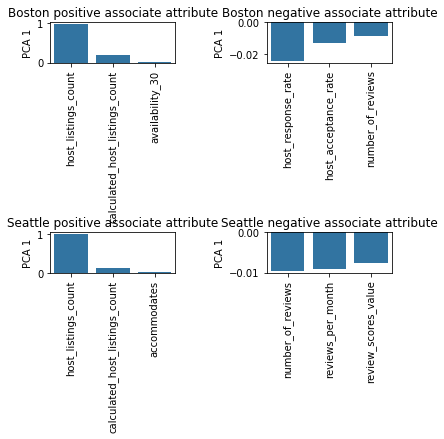

In [408]:
#plot side by side PCA_comps


rows = 2
cols = 2
#ax, fig = plt.subplots(rows, cols)
df_pca = pd.DataFrame(pca_boston["PCA 1"].sort_values(ascending=False).head(3))

plt.subplot(rows, cols, 1)
column = df1.columns
plt.title("Boston positive associate attribute")
sns.barplot(data = df_pca, x = df_pca.index.values, y = "PCA 1", color = base_color);
plt.xticks(rotation = 90);

df_pca = pd.DataFrame(pca_boston["PCA 1"].sort_values(ascending=True).head(3))

plt.subplot(rows, cols, 2)
column = df2.columns
plt.title("Boston negative associate attribute")
sns.barplot(data = df_pca, x = df_pca.index.values, y = "PCA 1", color = base_color);
plt.xticks(rotation = 90);
plt.tight_layout();


df_pca = pd.DataFrame(pca_seattle["PCA 1"].sort_values(ascending=False).head(3))
plt.subplot(rows, cols, 3)
column = df1.columns
plt.title("Seattle positive associate attribute")
sns.barplot(data = df_pca, x = df_pca.index.values, y = "PCA 1", color = base_color);
plt.xticks(rotation = 90);

df_pca = pd.DataFrame(pca_seattle["PCA 1"].sort_values(ascending=True).head(3))
plt.subplot(rows, cols, 4)
column = df2.columns
plt.title("Seattle negative associate attribute")
sns.barplot(data = df_pca, x = df_pca.index.values, y = "PCA 1", color = base_color);
plt.xticks(rotation = 90);
plt.tight_layout();

plt.show();




### Modeling

In [409]:
def feature_plot(importances, X_train, y_train, n = 10):
    
    # Display the five most important features
    indices = np.argsort(importances)[::-1]
    columns = X_train.columns.values[indices[:n]]
    values = importances[indices][:n]

    # Creat the plot
    fig = plt.figure(figsize = (9,5))
    plt.title("Normalized Weights for First Five Most Predictive Features", fontsize = 16)
    plt.bar(np.arange(n), values, width = 0.6, align="center", color = 'blue', \
          label = "Feature Weight")
    plt.bar(np.arange(n) - 0.3, np.cumsum(values), width = 0.2, align = "center", color = 'navy', \
          label = "Cumulative Feature Weight")
    plt.xticks(np.arange(n), columns)
    plt.xlim((-0.5, n-0.5))
    plt.ylabel("Weight", fontsize = 12)
    plt.xlabel("Feature", fontsize = 12)
    plt.xticks(rotation = 90);
    
    plt.legend(loc = 'upper center')
    plt.tight_layout()
    plt.show()  

/Users/JamesAir/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


RMSE: 73.502145


/Users/JamesAir/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


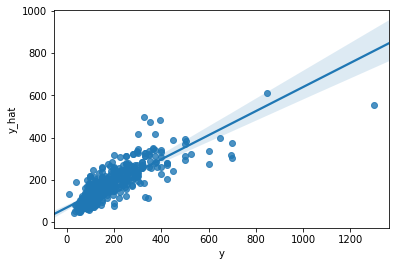

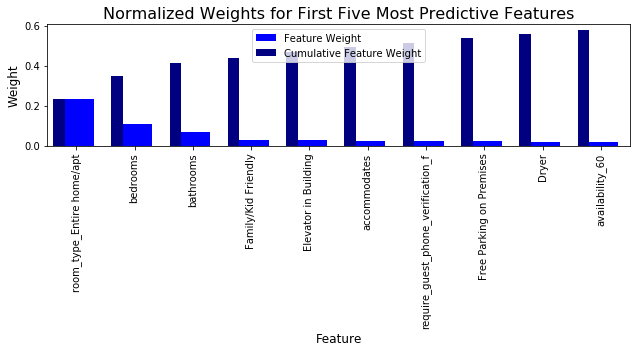

In [414]:
y = listing_dummies[listing_dummies['city_Boston']==1]['price']
X = listing_dummies[listing_dummies['city_Boston']==1].iloc[:, 1:]
os.environ['KMP_DUPLICATE_LIB_OK']='True'
# Split the 'features' and 'income' data into training and testing sets

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size = 0.2, 
                                                    random_state = 0)



model_XGB = XGBRegressor(random_state=1) 
model_XGB.fit(X_train,y_train)
preds_XGB = model_XGB.predict(X_test)
rmse_XGB = np.sqrt(mean_squared_error(y_test, preds_XGB))
print("RMSE: %f" % (rmse_XGB))
sb.regplot(x = y_test.tolist(), y=preds_XGB);
plt.xlabel('y');
plt.ylabel('y_hat');
importances = model_XGB.feature_importances_
feature_plot(importances, X_train, y_train)

/Users/JamesAir/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


RMSE: 42.812702


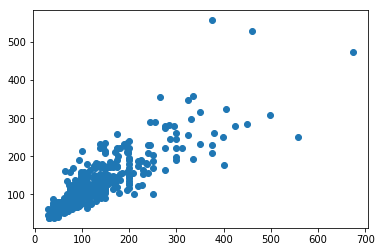

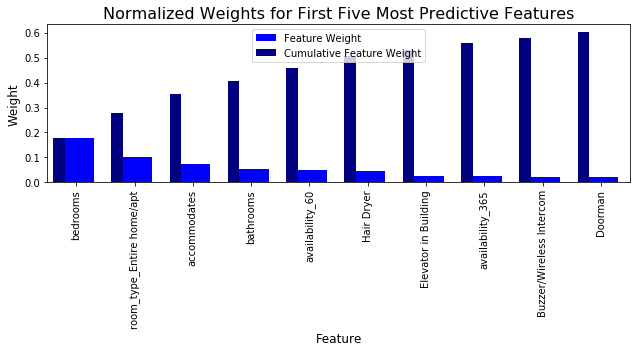

In [205]:
y = listing_dummies[listing_dummies['city_Boston']==0]['price']
X = listing_dummies[listing_dummies['city_Boston']==0].iloc[:, 1:]
os.environ['KMP_DUPLICATE_LIB_OK']='True'
# Split the 'features' and 'income' data into training and testing sets

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size = 0.2, 
                                                    random_state = 0)



model_XGB = XGBRegressor(random_state=1) 
model_XGB.fit(X_train,y_train)
preds_XGB = model_XGB.predict(X_test)
rmse_XGB = np.sqrt(mean_squared_error(y_test, preds_XGB))
print("RMSE: %f" % (rmse_XGB))
plt.scatter(y_test.tolist(), preds_XGB)
importances = model_XGB.feature_importances_
feature_plot(importances, X_train, y_train)

In [206]:

y = listing_dummies[listing_dummies['city_Boston']==1]['review_scores_value']
X = listing_dummies[listing_dummies['city_Boston']==1].drop(['review_scores_value'], axis=1)

/Users/JamesAir/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


RMSE: 0.885373


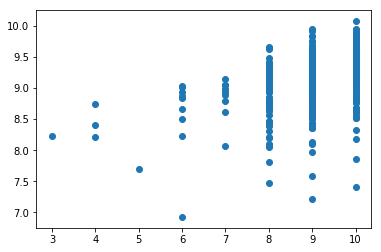

In [207]:

# Split the 'features' and 'income' data into training and testing sets

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size = 0.2, 
                                                    random_state = 0)



model_XGB = XGBRegressor(random_state=1) 


model_XGB.fit(X_train,y_train)
preds_XGB = model_XGB.predict(X_test)
rmse_XGB = np.sqrt(mean_squared_error(y_test, preds_XGB))
print("RMSE: %f" % (rmse_XGB))

plt.scatter(y_test.tolist(), preds_XGB)

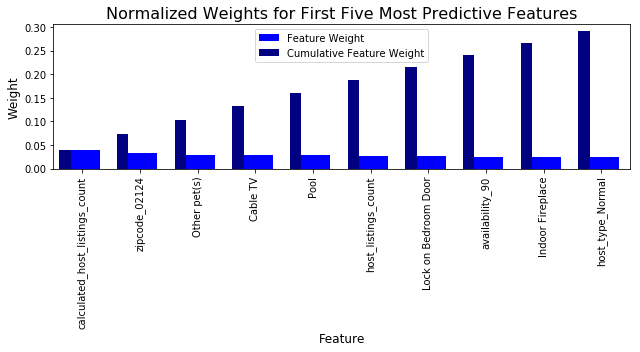

In [208]:
importances = model_XGB.feature_importances_
feature_plot(importances, X_train, y_train)

In [209]:

y = listing_dummies[listing_dummies['city_Boston']==0]['review_scores_value']
X = listing_dummies[listing_dummies['city_Boston']==0].drop(['review_scores_value'], axis=1)

/Users/JamesAir/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


RMSE: 0.711051


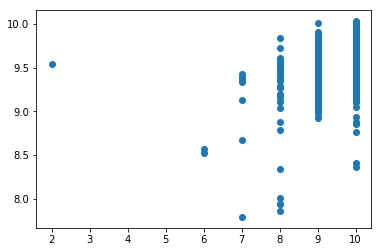

In [210]:

# Split the 'features' and 'income' data into training and testing sets

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size = 0.2, 
                                                    random_state = 0)



model_XGB = XGBRegressor(random_state=1) 


model_XGB.fit(X_train,y_train)
preds_XGB = model_XGB.predict(X_test)
rmse_XGB = np.sqrt(mean_squared_error(y_test, preds_XGB))
print("RMSE: %f" % (rmse_XGB))

plt.scatter(y_test.tolist(), preds_XGB)

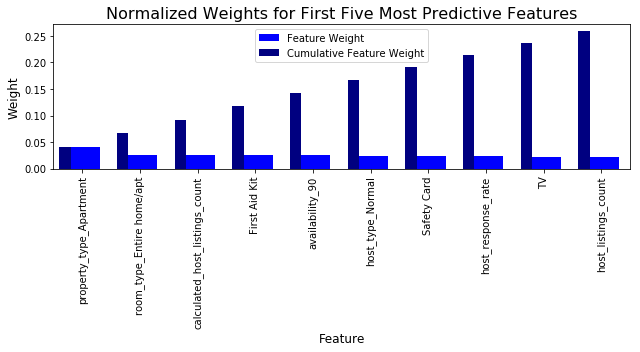

In [211]:
importances = model_XGB.feature_importances_
feature_plot(importances, X_train, y_train)

**Business Understanding:** This data contain a lot of parameters related to Boston and Seattle Airbnb data. Airbnb is in the business of offering host locations for cutomers. Like Amazon, those hosts rely on price and review score. I am assuming that review score correlates with profitability.

**Data Understanding:** The data is very dirty but contain a lot of informative insights. So we are required to do a lot of data preprocessing with the data.

**Data cleaning and preprocessing:** I spent a lot of time on cleaning the data and you can see from the code that the majority of my work is on data processing. At first, I started by removing columns that are not needed to trim the matrix, then I started remvoing missing data, then removing null data, and then creating dummy variables for categorical columns.

**Analysis:** I created a heatmap to show the correlation of data and removed data that are strongly correlated with each other.

**Model:** I used a base model which is linear regression which performed poorly. Then, I used decision tree regressor. The model score is 99%.

**Deploy:** To deploy this model quickly, we need to neglict calender list since it is huge and rely on the 9 features that we have except host diff. Our model still give 99% accuracy for Boston and Seattle but does not give good results for New York and San Franscisco indicating that each city need its own model and that we need to aggregate data.